## **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [18]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Most important package
import numpy as np

# The reinforcement learning environment
from gridworld import GridWorld

# Configure nice figures
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(14,7)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed and solutions using modules other than `numpy` will be sent for re-submission. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

---
## **1. Reinforcement Learning, introduction**
In the previous assignments we have explored supervised learning, in other words, methods that train a model based on known inputs and targets. This time, we will instead look at a branch of machine learning that is much closer to the intuitive notion of "learning". Reinforcement learning, or RL for short, does not work with inputs and targets, but instead learns by performing **actions** in an **environment** and observing the generated **rewards**.

RL is a very broad concept and many different algorithms have been deviced based on these general concepts of actions and rewards. Perhaps the main advantage of RL over other machine learning techniques is that we do not explicitly tell the model what the right answer is (like we have done in the previous assignments), but instead only tell the model when the desired outcome has been acheived. This might seem like the same thing at first, but the key difference is that RL allows the model to device solutions that outperform the human teacher. This is usually not possible in traditional supervised learning since the model can only get as good as the training data (the teacher). With the freedom to explore new strategies, which is inherent to RL, this is no longer true and some truly astounding results have been acheved. The most famous example is probably AlphaGo, the first computer program to beat a human expert in the board game Go. [Here is an excellent documentary](https://youtu.be/WXuK6gekU1Y), if you have some time to spare. For those of you that want a quicker and more fun example, [here is a video about RL agents playing hide and seek](https://youtu.be/kopoLzvh5jY), which very clearly demonstrates the power of RL to invent new and hidden strategies.

Of course, these examples are from the very forefront of current research in RL, and are unfortunately too complex for this assignment. We will instead work on a much simpler problem, but the core concepts that you will implement and investigate here are the same that made the above possible.

### **1.1 Getting to know the environment interface**
To do this assignment you must first get familiar with the code interface to the environment, or "World", as we will call it. You will work with a special type of environment called a **GridWorld**. The GridWorld is, as the name suggests, a world where each state is represented by a square on a grid. To create an instance of a GridWorld, run the following code. You can change the input number to select a different world. You will work with worlds 1-4, but there are other optional worlds as well, which we encourage you to explore at the end of the notebook.

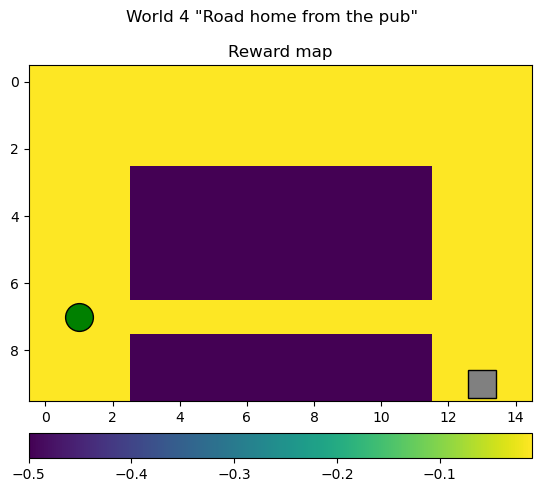

In [120]:
W = GridWorld(4)
W.init()
W.draw()

#### **<span style="color:red">Question 1:</span>**
The colored background represents the reward for entering each state. Notice that all rewards are negative. Can you think of why this is important?

#### **<span style="color:green">Answer:</span>**
From the plot we assume that we want to model to avoid obstacles. To achieve that goal, it's better to let model learning how to "lose less reward" instead of "collect more reward". Otherwise the model may tend to repeatly collect rewards and "ignore" the true goal.

The **Agent** is represented by the gray square, and will traverse the environment in order to reach the **goal** state, represented by the green circle.
You can access all information you need regarding the state of the GridWorld by the methods of the World class. Here is the full list with explanations for each method:

* `getWorldSize()` - Returns a tuple with the size of each dimension in the state space. For the GridWorlds, this is the y-size and x-size of the grid.
* `getDimensionNames()` - Returns a list with the names for each dimension. This is only used to understand the world better, and should not be used to design the algorithm.
* `getActions()` - Returns a list of available actions in the form of strings. These are the only accepted values to pass to `doAction`.
* `init()` - Initializes the World. For example this resets the position of the agent in the GridWorlds. Do this at the beginning of each epoch.
* `getState()` - Returns the current state of the World, which for a GridWorld is the position of the agent.
* `doAction(act)` - Performs an action and returns a 2-tuple indicating if the actions was valid, and the corresponding reward.
* `draw(epoch, Q)` - Update any plots associated with the World. The two arguments are optional but will include more information in the plots if you provide them.

Here are some examples:

In [20]:
W = GridWorld(1)
print("World size:", W.getWorldSize())
print("Dimension names:", W.getDimensionNames())
print("Actions:", W.getActions())

World size: (10, 15)
Dimension names: ['Y', 'X']
Actions: ['Down', 'Up', 'Right', 'Left']


Here is an example of some actions in the first GridWorld. Read the code and output and make sure you understand how this works before proceeding. You can quickly run the cell multiple times by holding `Ctrl` and pressing `Enter` to generate a new output.

In [21]:
W = GridWorld(1)
W.init()

# Check state
state, isTerm = W.getState()
print(f"State initialized to {state}.")

# Make action
a = "Down"
isValid, reward = W.doAction(a)
print(f"Action '{a}' was {'' if isValid else 'not '}valid and gave a reward of {reward}.")

# Check state
state, isTerm = W.getState()
print(f"State is {state} and is {('' if isTerm else 'not ')}terminal.")

# Make action
a = "Right"
isValid, reward = W.doAction(a)
print(f"Action '{a}' was {'' if isValid else 'not '}valid and gave a reward of {reward}.")

# Check state
state, isTerm = W.getState()
print(f"State is {state} and is {('' if isTerm else 'not ')}terminal.")

State initialized to (3, 9).
Action 'Down' was valid and gave a reward of -0.1.
State is (4, 9) and is not terminal.
Action 'Right' was valid and gave a reward of -0.1.
State is (4, 10) and is not terminal.


---
## **2. Implementing the Q-learning algorithm**
You will now implement the main algorithm of this assignment, **Q-learning**. This algorithm is powerful since it allows the simultaneous exploration of different **policies**. This is done by a state-action table **Q**, keeping track of the expected reward associated with each action in each state. By iteratively updating these estimates as we get new rewards, the policies explored by the agent eventually converges to the optimal policy. This can all be summarized in the following equation:

$$ \large Q\left(s_t,a\right) \leftarrow \underbrace{Q\left(s_t,a\right)}_{\mathrm{Old \space value}} \cdot \left(1-\alpha\right) + \alpha \cdot \underbrace{\left(r + \gamma V\left(s_{t+1}\right)\right)}_{\mathrm{New \space estimate}} $$

This defines that the value of $Q$ in a state $s_t$ for action $a$, i.e $Q\left(s_t,a\right)$, should be updated as a weighted average of the old value and a new estimate, where the weighting is based on the learning rate $\alpha \in (0,1)$. The new estimate is a combination of the reward $r$ for the action we are updating, and the estimated value $V$ of the next state $s_{t+1}$, discounted by the factor $\gamma \in (0,1]$. By increasing $\gamma$, the future value is weighted higher, which is why we say that this optimizes for long-term rewards.

### **2.1 The training function**
First, you will implement the Q-learning algorithm training loop in the following function. The inputs to this function is a World object, and a dictionary for any parameters needed for the training. This dictionary will contain the following parameters, which you will need `params = {"Epochs": 100, "MaxSteps": 100: "Alpha": 0.5: "Gamma": 0.9, "ExpRate": 0.5, "DrawInterval": 100}`. Note that these values are only examples, you will have to change them when optimizing each world. You access the content of the dictionary by it's name, for example `params["Gamma"]`. Using this style makes it very easy later in the notebook to try new worlds and parameter combinations.

Finally before you begin, here are some concrete tips to keep in mind while working:
* Try your code often! Jump ahead to section 3.1 to easily run the training in the first GridWorld.
* As part of this implementation, you must also implement the functions `getpolicy` and `getvalue` in `utils.py`. When you have implemented these the `draw` function will automatically show the results of the training!

In [33]:
def QLearning(World, params={}):
    
    # Init world and get size of dimensions
    WSize = World.getWorldSize()
    A = World.getActions()
    NA = len(A)

    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    # Initialize the Q-matrix (use the size variables above)
    
    # Q = np.zeros((WSize + (NA,)))
    Q = np.full((WSize + (NA,)), -0.1)
    # Q(s(Y,X),a)

    # eps = params["Eps"]
    alpha = params["LR"]
    gamma = params["Gamma"]
    eps = params["Eps"]
    
    for i in range(params["Epochs"]):
        World.init()
        
        # Limiting the number of steps in an epoch prevents getting stuck in infinite loops
        for j in range(params["MaxSteps"]):
            state, isTerm = World.getState()
            sy,sx = state

            if np.random.uniform() < eps:
                # random
                actionIndex = np.random.randint(NA)
            else:
                # greedy
                actionIndex = np.argmax(Q[sy, sx])

            action = A[actionIndex]

            isValid, reward = World.doAction(action)
            # if isValid == False:
            #     continue

            state, isTerm = World.getState()
            newsy, newsx = state
            Q[sy, sx, actionIndex] = (1-alpha)*Q[sy, sx, actionIndex] + alpha*(reward + gamma*np.max(Q[newsy, newsx,:]))
            
            if isTerm:
                break    
        
        # eps *= 1-1/params["Epochs"]
        # decrease eps

        
        # Update plots with regular intervals
        if ((i+1) % params["DrawInterval"] == 0) or (i == params["Epochs"]-1):
            World.draw(epoch=(i+1), Q=Q)
    
    # ============================================
        
    return Q

### **2.2 The test function**
It's important to test the performance of the trained model. This *could* be done with some heuristic function that measures properties such as path lenghts and total rewards, but here we choose to instead use a more direct evaluation method. In the following function you should implement a test loop where you follow the optimal policy and draw the world after *each* action. Since this is code to test the trained model, you should not update Q, only use it to determine the optimal actions.

In [23]:
def QLearningTest(W, Q, params={}):
    
    # The number of epochs is now the number of tests runs to do
    for i in range(params["Epochs"]):
        
        # Init the world and get state
        W.init()
        A = W.getActions()
        s,_ = W.getState()

        # Again we limit the number of steps to prevent infinite loops
        for j in range(params["MaxSteps"]):
            
            # --------------------------------------------
            # === Your code here =========================
            # --------------------------------------------
            
            # Choose and perform optimal action from policy
            state, isTerm = W.getState()
            sy,sx = state
            actionIndex = np.argmax(Q[sy, sx])
            isValid, reward = W.doAction(A[actionIndex])


            # ============================================
            
            # Get updated state and draw
            s,isTerm = W.getState()
            W.draw(epoch=(i+1), Q=Q)
            
            # Check if goal
            if isTerm:
                break

---
## **3. Optimizing the different worlds**

In this section you will optimize the hyperparameters to train the 4 first GridWorlds. 

### **3.1 GridWorld 1**
We start with the simplest of the worlds, "Annoying block". The policy should converge without much difficulty, so use this as a test to see if your implementaion is correct. If you use a good set of hyperparameters, you can expect a rather neat policy in about 1000 epochs.

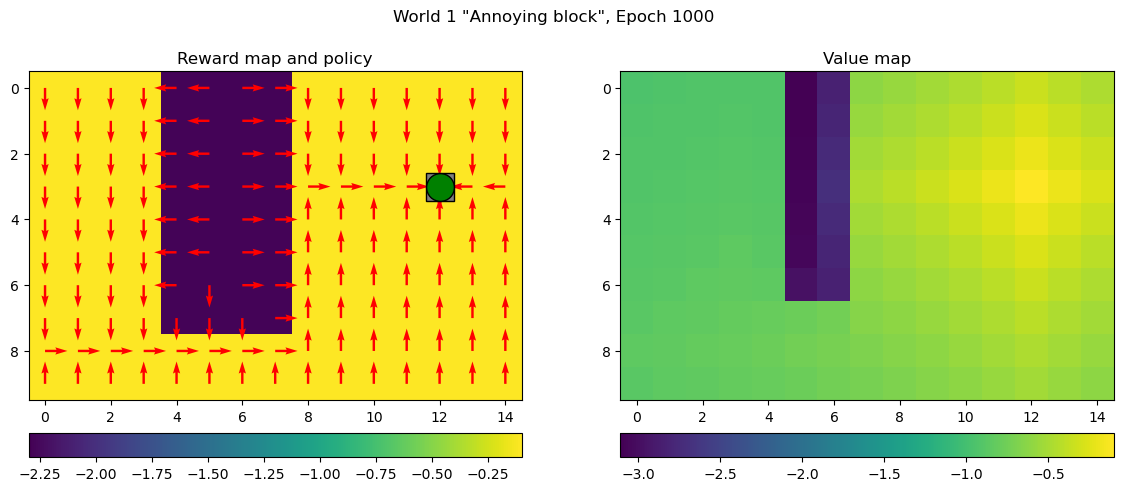

In [58]:
W1 = GridWorld(1)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q1 = QLearning(W1, params={"LR": 0.9, "Gamma": 0.90, "Eps": 0.8, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable.

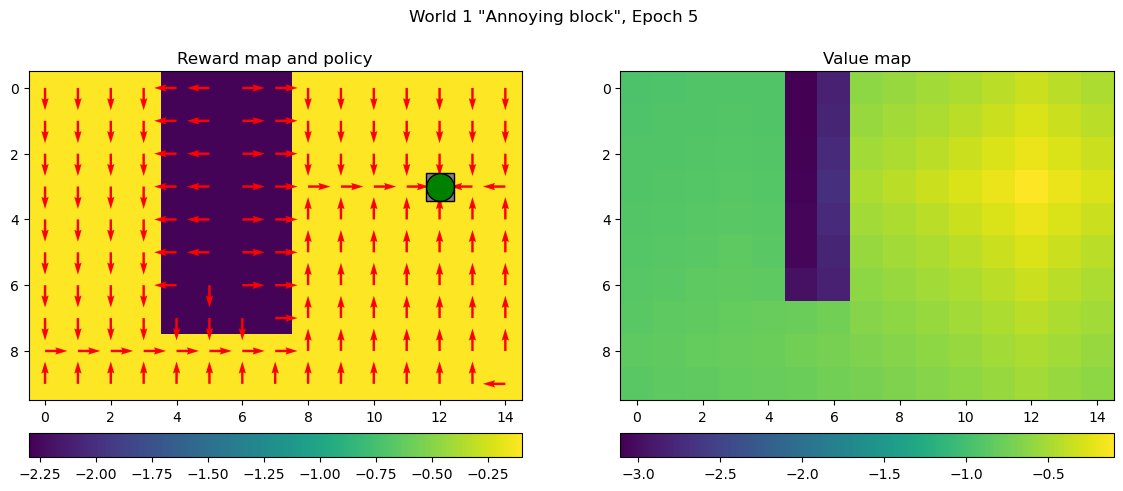

In [38]:
QLearningTest(W=W1, Q=Q1, params={"Epochs": 5, "MaxSteps": 100})

#### **<span style="color:red">Question 2:</span>**
1. Describe World 1.
2. What is the goal for the agent in this world?
3. What is a good choice of learning rate in this world? Motvate your answer.

#### **<span style="color:green">Answer:</span>**
1. Describe World 1.
    - In world 1, there's a obstacle shown by negative rewards significantly smaller than other area. And the other area is passable areas.
2. What is the goal for the agent in this world?
    - It needs our agent to  reach the goal and circumvent or escape from the obstacle during it's approaching towards goal.
3. What is a good choice of learning rate in this world? Motivate your answer.
    - The problem we are facing is rather simple and clear, we can have a high learning rate and don't need to worry too much about local minimum.

Now continue optimizing worlds 2-4. Note that the optimal hyperparmeters potentially are very different for each world.

### **3.2 GridWorld 2**

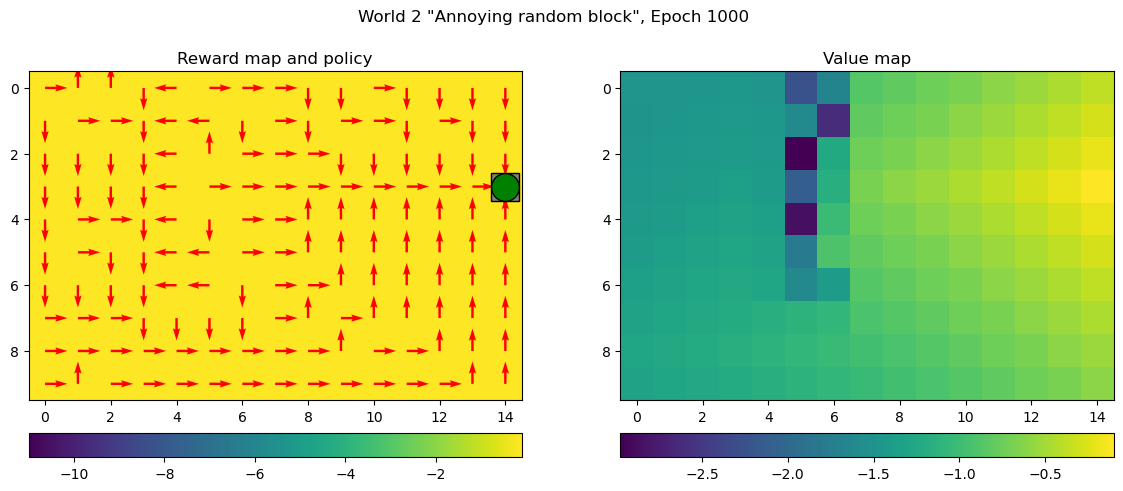

In [78]:
W2 = GridWorld(2)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q2 = QLearning(W2, params={"LR": 0.3, "Gamma": 0.95, "Eps": 0.7, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable.

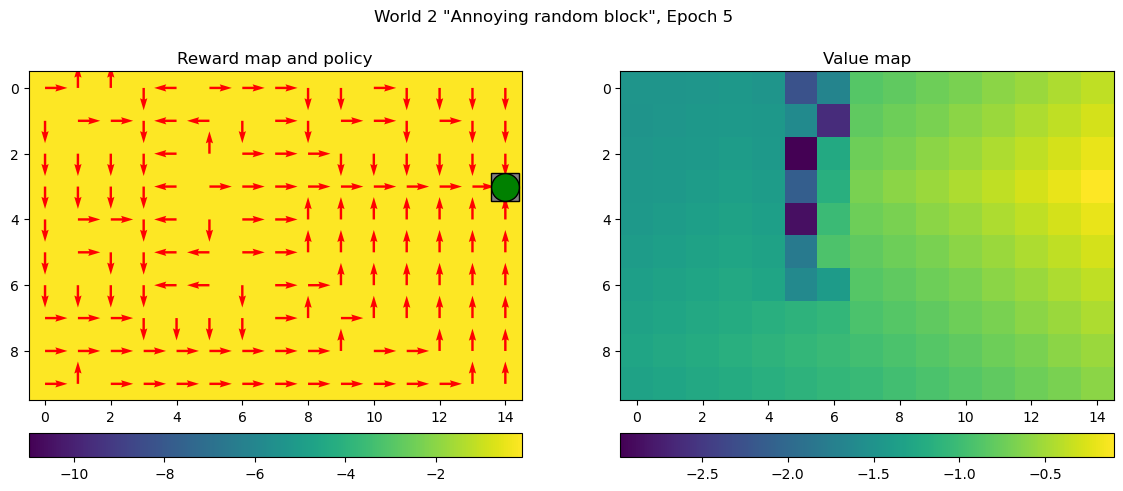

In [79]:
QLearningTest(W=W2, Q=Q2, params={"Epochs": 5, "MaxSteps": 100})

#### **<span style="color:red">Question 3:</span>**
1. Describe World 2.
2. This world has a hidden trick. Describe this trick and why this can be solved with reinforcement learning.
3. What is the goal for the agent in this world?
4. What is a good choice of learning rate in this world? Motvate your answer.
5. Compared to the optimal policy in World 1, how do we expect the optimal policy to look in this world? Motivate your answer.

#### **<span style="color:green">Answer:</span>**
1. Describe World 2.
    - Similar to world 1, but this time the obstacle will randomly occur by a chance in each world when initiation.
2. This world has a hidden trick. Describe this trick and why this can be solved with reinforcement learning.
    - The obstacle randomly occurs by a chance of 0.2, and the negative reward of the obstacle is much less than it was in world 1. Reinforcement learning can solve this because it can in a sense "remember" where the obstacle used to be when updating value function and keep a portion of previous memories, and the greater absolute value of negative rewards can help such "memories" survives during iterations without obstacle in the world.
3. What is the goal for the agent in this world?
    - Similar to world 1, but this time the agent need to be aware of the possible obstacle even when the obstacle may not be there every time.
4. What is a good choice of learning rate in this world? Motvate your answer.
    - We set it a little bit lower for a reason that we want the model keeps more experience learned from worlds which obstacle occurs and not losing such experience when training on worlds without obstacles.
5. Compared to the optimal policy in World 1, how do we expect the optimal policy to look in this world? Motivate your answer.
    - The expected optimal policy in world 1 should take leaving the obstacle as the first priority when the agent is in the obstacles. But in world 2, the agent can tend to directly goes towards the goal when it's in the area where obstacles might occur. Because the obstacle won't occur every time so the optimal policy is to take the shortest path towards goal when there's no obstacles.

### **3.3 GridWorld 3**

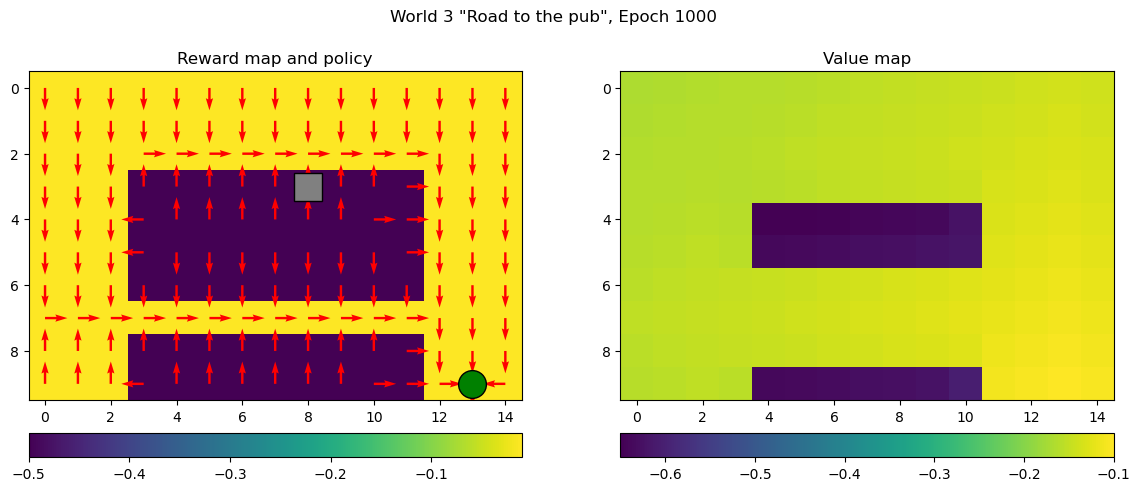

In [104]:
W3 = GridWorld(3)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q3 = QLearning(W3, params={"LR": 0.8, "Gamma": 0.95, "Eps": 0.9, "Epochs": 1000, "MaxSteps": 500, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable.

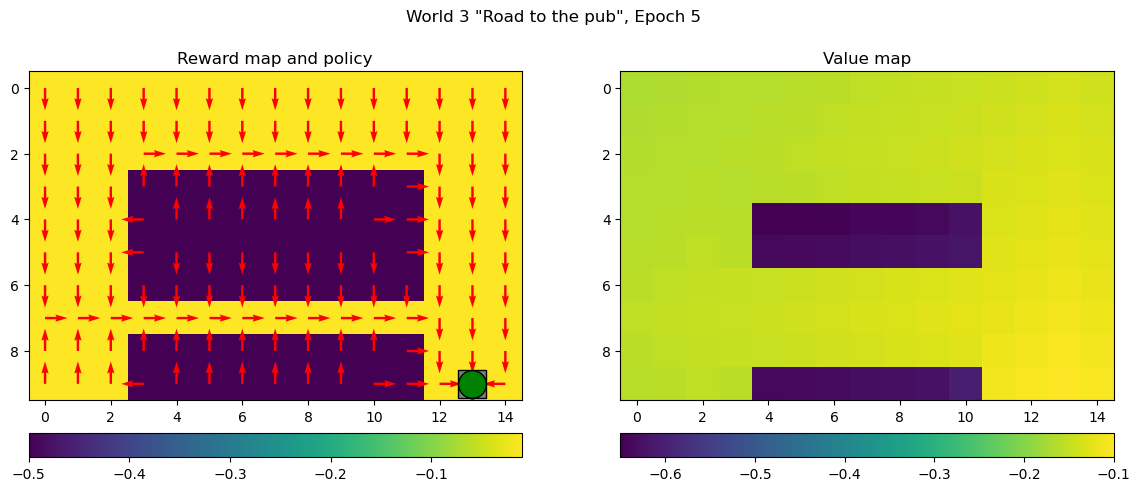

In [110]:
QLearningTest(W=W3, Q=Q3, params={"Epochs": 5, "MaxSteps": 100})

#### **<span style="color:red">Question 4:</span>**
1. Describe World 3.
2. From the perspective of the learning algorithm, how does this world compare to World 1?
3. What is the goal for the agent in this world?
4. Is it possible to get a good policy in every state in this world? If so, which hyperparameter is particulary important to acheive this?

#### **<span style="color:green">Answer:</span>**
1. Describe World 3.
    - Similar with world 1, but this time the intial position of agent is fixed, and there is a passable path through the obstacle.
2. From the perspective of the learning algorithm, how does this world compare to World 1?
    - It should be easier to get a partical policy due to the fixed initial location of agent make the correct path to goal fixed too. But it would be harder to get a policy also fits for agents with random initial position because it would be harder for this fixed-start-location agent to traverse through all "unnecessary" grid and generate proper policy for that.
3. What is the goal for the agent in this world?
    - Approch the goal and also avoid obstacles.
4. Is it possible to get a good policy in every state in this world? If so, which hyperparameter is particulary important to acheive this?
    - As shown above, it is possible. The exploration factor is the most important one because we need a high explore rate to make our agent try different actions to go through every state and generate corresponding policy. Without a high explore rate. The agent will tend to follow the optimized path towards goal and ignore other states.

### **3.4 GridWorld 4**

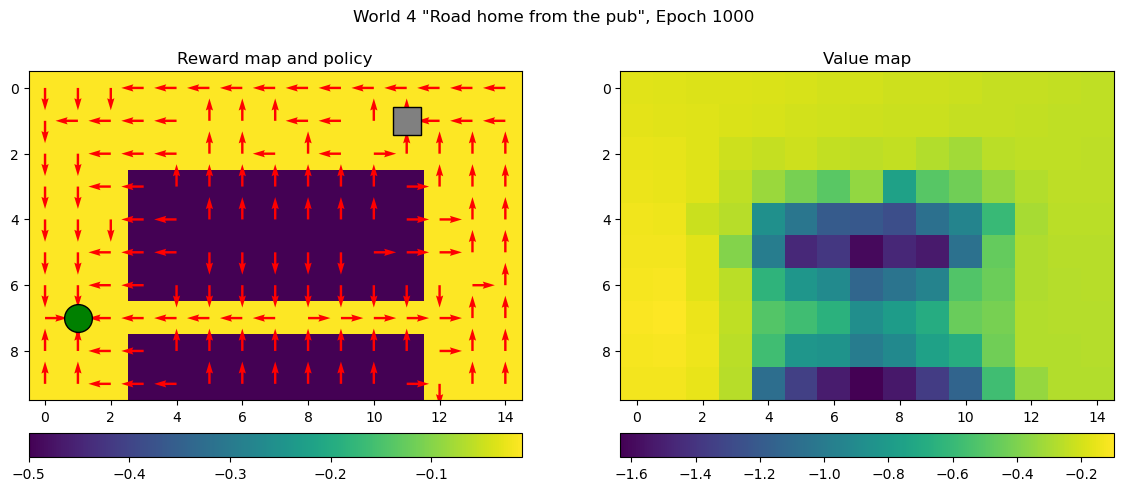

In [145]:
W4 = GridWorld(4)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q4 = QLearning(W4, params={"LR": 0.1, "Gamma": 0.97, "Eps": 0.98, "Epochs": 1000, "MaxSteps": 1000, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable. **Important**: You might think the policy above looks bad, but we encourage you to run this test even if you think it's not optimal. It might give you some insight into the world behaviour.

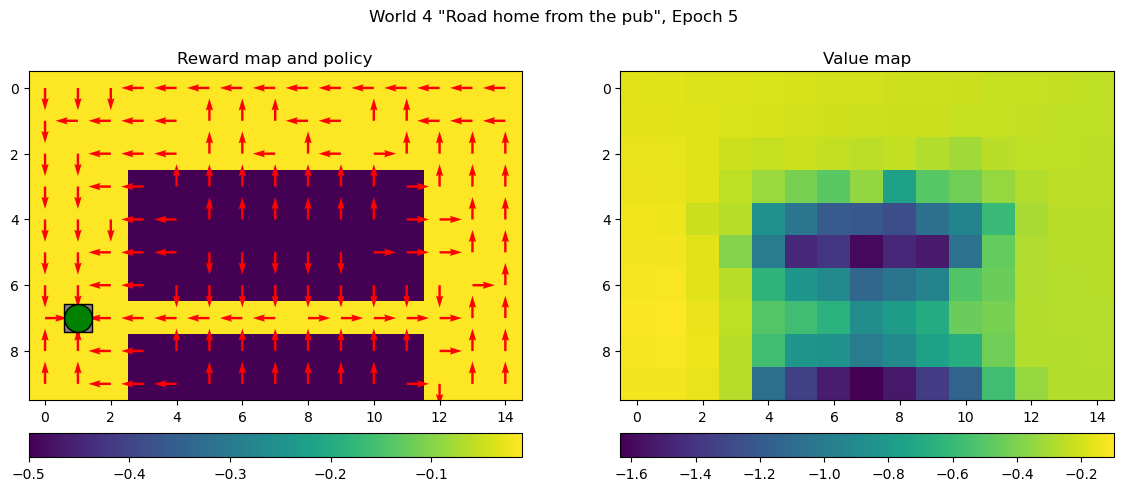

In [146]:
QLearningTest(W=W4, Q=Q4, params={"Epochs": 5, "MaxSteps": 100})

#### **<span style="color:red">Question 5:</span>**
1. Describe World 4 using your own words. 
2. This world has a hidden trick. What is it, and how does this world differ from World 3?
3. What is the goal for the agent in this world?
4. What is a good choice of learning rate in this world? Motvate your answer.
5. How should we expect the optimal policy too look like? In other words, what is the optimal path from start to goal in this world? Motivate your answer.

#### **<span style="color:green">Answer:</span>**
1. Describe World 4 using your own words. 
    - Similar with world 3, but this time the position of agent and goal is exchanged with each other.
2. This world has a hidden trick. What is it, and how does this world differ from World 3?
    - The .doAction() have a 30% chance to move randomly instead of follow the order. It makes the model tend to avoid go through the "shortcut" between obstacles because the agent will randomly hit the obstable by a chance when it's close to the obstacle.
3. What is the goal for the agent in this world?
    - Reach the goal and avoid obstacles. Meanwhile avoid the risk of randomly hit obstacle when it's nearing obstacle.
4. What is a good choice of learning rate in this world? Motvate your answer.
    - it would be better to set a lower learning rate because the randomness may easily lead towards local minimum. And we need the previous experience learned to help the model not to be affected by such randomness.
5. How should we expect the optimal policy too look like? In other words, what is the optimal path from start to goal in this world? Motivate your answer.
    - The optimal policy should lead the agent took a roundabout path and keep a distance with obstacle. By the reasons discussed above that the random action may lead the agent towards obstacle.

---
## **4. Investigating the effects of hyperparameters**
You will now design a series of experiments to show the impact of the three main hyperparameters - learning rate, discount factor, and exploration rate - in different environments. You are free to extend the experiments as you see fit in order to make your point in the discussions, but a recommended strategy is to try two extreme cases (low vs high values). For each parameter, there is one world in particular of the four you have already used where it is easy to show the effects we are looking for. Figuring out which worlds is part of the excercise.

### **4.1 Learning rate**

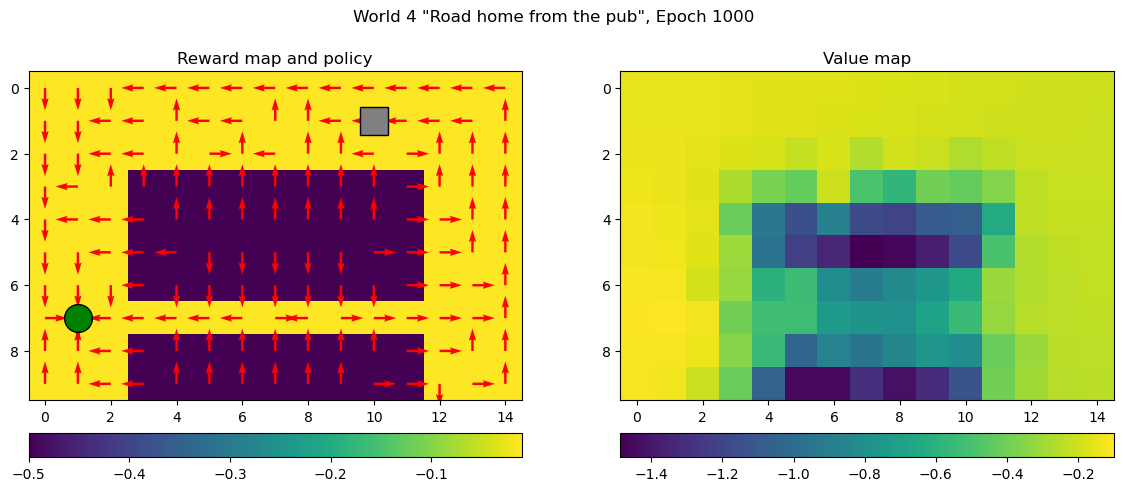

In [156]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

W_LR = GridWorld(4)
Q_41_L = QLearning(W_LR, params={"LR": 0.1, "Gamma": 0.97, "Eps": 0.98, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

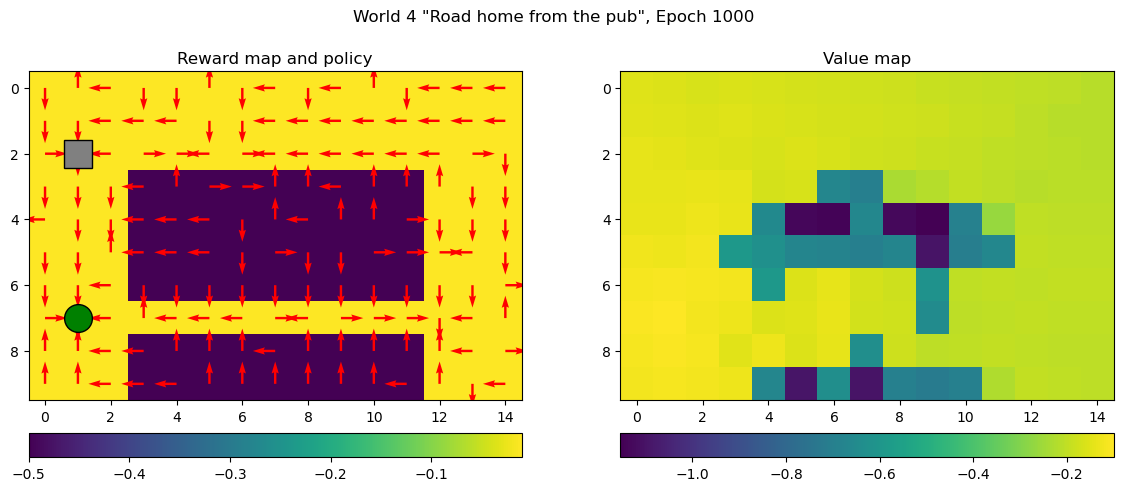

In [149]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q_LR_H = QLearning(W_LR, params={"LR": 0.95, "Gamma": 0.97, "Eps": 0.98, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

#### **<span style="color:red">Question 6:</span>**
Explain your experiment and results, and why you choose this world (your answers should be based on the output of the cells above).

#### **<span style="color:green">Answer:</span>**
We chose world 4 with a comparation of LR = 0.95 and 0.1. The motivation we chose this world is that the randomness will cause trouble of convergence. From the result we can see that a low learning rate can yield a rather decent policy, but a high learning rate will make the model heavily affected by randomness because the perturbation will easily overwrite the correct experience we learned.

### **4.2 Discount factor (gamma)**

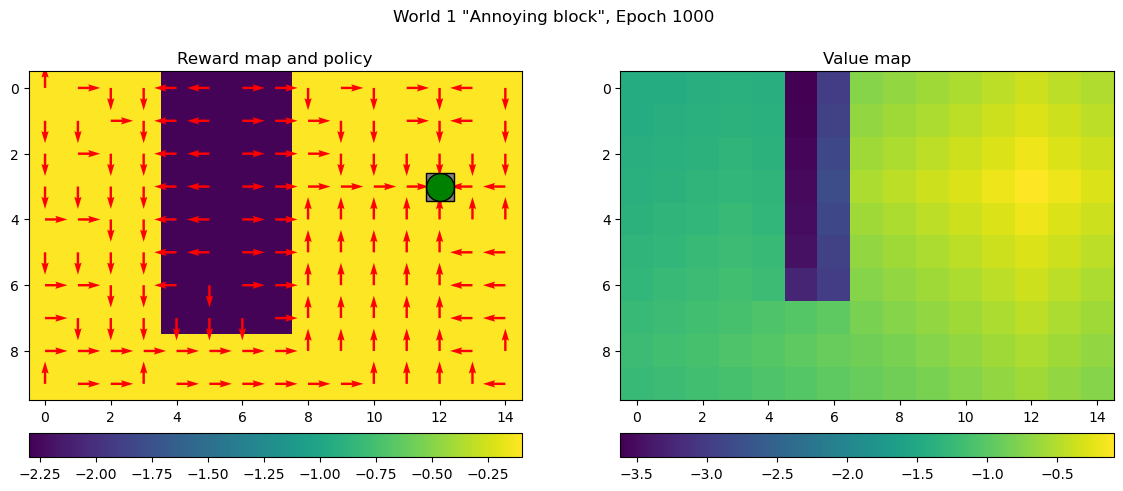

In [164]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

W_DF = GridWorld(1)
Q_DF_L = QLearning(W_DF, params={"LR": 0.3, "Gamma": 0.95, "Eps": 0.7, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

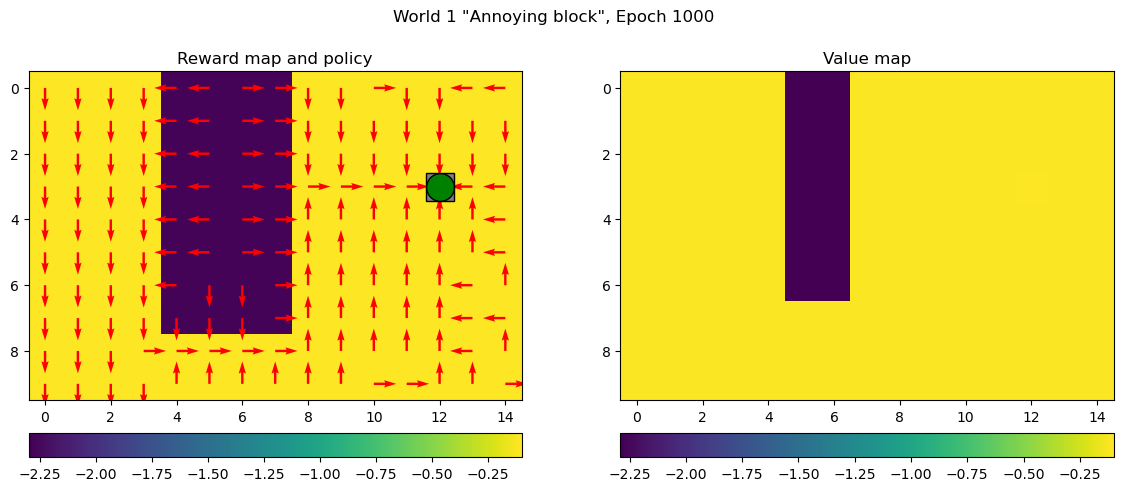

In [165]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q_DF_H = QLearning(W_DF, params={"LR": 0.3, "Gamma": 0.1, "Eps": 0.7, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

#### **<span style="color:red">Question 7:</span>**
Explain your experiment and results, and why you choose this world (your answers should be based on the output of the cells above).

#### **<span style="color:green">Answer:</span>**
We chose world 1 beacause its the simplest problem and already enough to show the difference. We made a comparision between Gamma = 0.95 and Gamma = 0.1. We can see that for a high gamma it yields a decent policy. But for a low gamma, the model can't "see" the distant long path towards the terminal because the instant reward always prevails over long-term values when updating Q matrix.

### **4.3 Exploration rate (epsilon)**

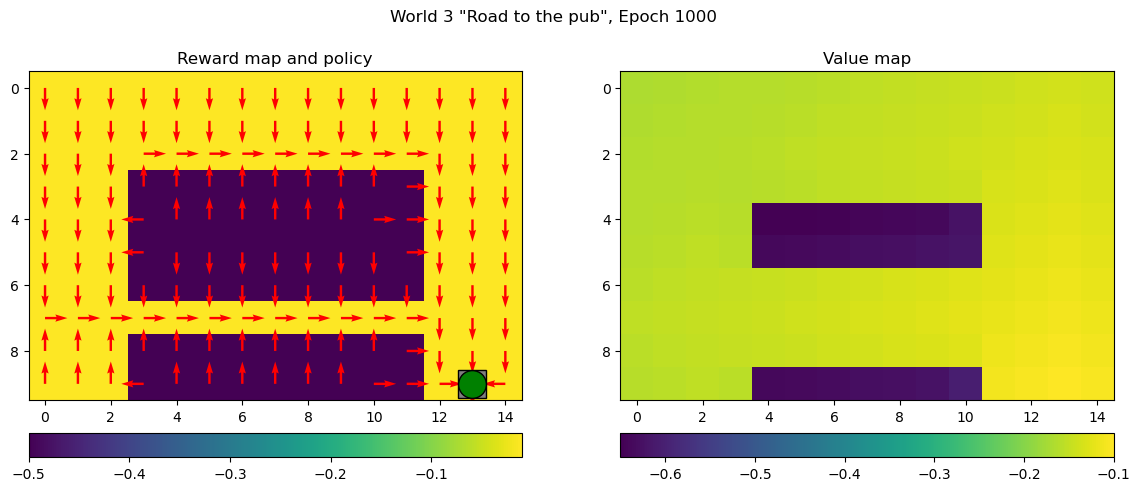

In [166]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

W_ER = GridWorld(3)
Q_ER_L = QLearning(W_ER, params={"LR": 0.8, "Gamma": 0.95, "Eps": 0.9, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

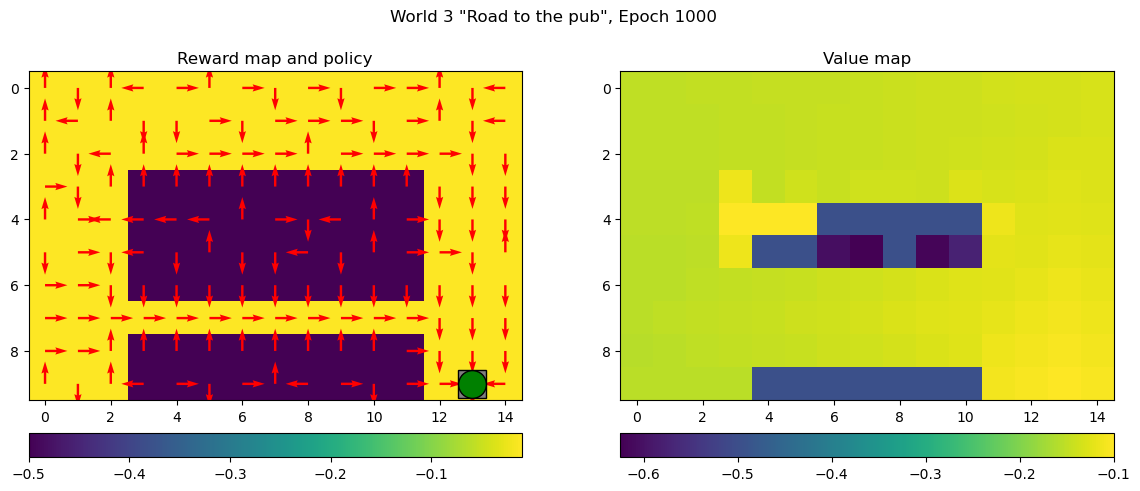

In [167]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q_ER_H = QLearning(W_ER, params={"LR": 0.8, "Gamma": 0.95, "Eps": 0.1, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

#### **<span style="color:red">Question 8:</span>**
Explain your experiment and results, and why you choose this world (your answers should be based on the output of the cells above).

#### **<span style="color:green">Answer:</span>**
We chose world 3 because the reason discussed above that the optimal policy for every state needs a high explore rate.
We made a comparision between eps = 0.9 and 0.1. We can see that a high explore rate yield a decent policy for every state. But a low explore rate made the policy generated only fits for the shortest path and perhaps a close nearing area.

---
## **5. Optional worlds**

You have now investigated the four most important GridWorlds in the lab, but we have also created some optional worlds (numbers 5 to 7) which you can try to solve. There is also World 8, but that is a special case, so scroll down a few cells if you are interested. Here is a brief description of World 5 to 7:
- World 5, Warpspace: As the name suggests, in this world there is one tile in which the agent enters warpspace and imediatly moves to another specific location. How do you think this will affect the learning?
- World 6, Torus: In this world, the opposite edges are connected together like a rolled-up paper. If you connect both the up-down and left-right edges, you get a mathematical shape called a torus which has no edges. This means that the closest path to the goal might not be obvious anymore.
- World 7, Steps: This world is a staircase of increasing rewards (although still all negative). However, moving up the stairs towards higher rewards also puts the agent further from the goal. So what is the optimal choice, to go for the long path with higher rewards, or to sprint throught the low rewards towards the goal. This depends on the value of gamma.

In [ ]:
WOpt = GridWorld( ??? )
QOpt = QLearning(WOpt, {"LR": 0.99, "Gamma": 0.9, "Eps": 0.9, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

In [ ]:
QLearningTest(W=WOpt, Q=QOpt, params={"Epochs": 5, "MaxSteps": 100})

### **5.1: World 8**

So far, every world has been a 2D-grid (y and x dimensions), and the four actions have been the same in every world. It has therefore been possible to write the code with this in mind, probably resulting in code where you index Q for example with `Q[s[0], s[1], a]` for a given state `s` and action `a`. However, it is possible to slightly rewrite the code to be independent of the number of dimensions in the state space, which means that we can then explore much more interesting worlds. It is also a nice excercise in how to write code that is general and modular. The way to do this is to index Q in the following way: `Q[(*s,a)]`. It's perfectly fine if you want to consider this as "python magic", but for the interested here is an explaination.

The state `s` is a tuple, for example `(3,6)`. A quirk in python is that tuples can be used to index into arrays, with each value in the tuple indexing separate dimensions in the array. For example, if Q is a 10x15x4 array, then `Q[(3,6)]` will return the vector of four values in Q that are in the 3rd row and 6th column (i.e. all the action values for state `s = (3,6)`). The problem is that we want to access the Q-value of a specific action when updating with a new reward. One might assume that `Q[s,a]` would work, but this now works differently since we explicitly index Q with not only a tuple. The solution is to remake a tuple that contains both `s` and `a`, and then index Q with this. We can do this by first unpacking the state tuple by calling `*s`, then creating a new tuple with `(*s,a)`, containing both the state and action. For example, if `s = (3,6)` and `a = 2`, then `(*s,a) = (3,6,2)`. We then use this tuple to index into Q as `Q[(*s,a)]`.

With this change to the implementation, we can for example extend the world to a 3D-grid, and your code should work the same. Let's try it in World 8, where the agent has the choice of moving between two floors of the map. This is shown as diagonal up or diagonal down arrows.

In [ ]:
W8 = GridWorld(8)
Q8 = QLearning(W8, {"LR": 0.99, "Gamma": 0.9, "Eps": 0.9, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

In [ ]:
QLearningTest(W=W8, Q=Q8, params={"Epochs": 5, "MaxSteps": 100})